# Predict regulatory regions from the DNA sequence with Janggu

In this notebook we illustrate several variants how to predict regulatory regions (of a toy example) from the DNA sequence.
The reference genome is made up of a concatenation of Oct4 and Mafk binding sites and we shall use all regions on chromosome 'pseudo1' as training
and 'pseudo2' as test chromosomes.

In [1]:
import os

import numpy as np
from keras import Model
from keras import backend as K
from keras.layers import Conv2D

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Reshape

from pkg_resources import resource_filename

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Bioseq
from janggu.data import Cover
from janggu.data import ReduceDim
from janggu.layers import DnaConv2D
from janggu.layers import LocalAveragePooling2D
from janggu.utils import ExportClustermap
from janggu.utils import ExportTsne
from janggu.utils import ExportTsv

from IPython.display import Image

np.random.seed(1234)

/home/wkopp/anaconda3/envs/jdev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, we need to specify the output directory in which the results are stored.

In [2]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

Specify the DNA sequence feature order. Order 1, 2 and 3 correspond to mono-, di- and tri-nucleotide based features (see Tutorial).

In [3]:
order = 3

In [4]:
# load the dataset
# The pseudo genome represents just a concatenation of all sequences
# in sample.fa and sample2.fa. Therefore, the results should be almost
# identically to the models obtained from classify_fasta.py.
REFGENOME = resource_filename('janggu', 'resources/pseudo_genome.fa')
# ROI contains regions spanning positive and negative examples
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')
# PEAK_FILE only contains positive examples
PEAK_FILE = resource_filename('janggu', 'resources/scores.bed')

Load the datasets for training and testing

In [5]:
# Training input and labels are purely defined genomic coordinates
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   order=order,
                                   cache=True)

LABELS = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               cache=True,
                               storage='sparse')


DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        order=order)

LABELS_TEST = Cover.create_from_bed('peaks',
                                    bedfiles=PEAK_FILE,
                                    roi=ROI_TEST_FILE,
                                    binsize=200,
                                    resolution=200,
                                    storage='sparse')


loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/08ee6c24faf5ebe600a7fc361e30a94ef2db75b41ffa057dabf5d5d7ef800e49.npz
loading from bed lazy loader
reload /home/wkopp/janggu_examples/datasets/peaks/db9ac6eef98519c37a8604886d1029a71d95374d8b9a6c10f283df557dd1cded.npz
loading from lazy loader
loading from bed lazy loader


## Example with Janggu model wrapper

Neural networks can also be defined using the Janggu wrappers for keras.
This offers a few additional advantages, including reduced redundancy for defining models or automated evaluation.

First we define model using keras using a method. The decorators will automatically instantiate the initial layers and the output layers with the correct dimensionality. In the example above, this needed to be specified explicitly.

In [1]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = DnaConv2D(Conv2D(params[0], (params[1], 1),
                                 activation=params[2]))(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


NameError: name 'inputlayer' is not defined

Now the model can be instantiated accordingly. We will also use a specific model name (which is optional).

In [10]:
modelname = 'dna2peak_ex1_order{}'.format(order)

In [11]:
# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=ReduceDim(LABELS),
                      name=modelname)

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])



Model fitting is similar as before.

Note also the use of ReduceDim which converts the original 4D Cover object to 2D table-like data structure. This is just for convenience, since it is also possible to set up a model as in the previous example.

In [12]:
hist = model.fit(DNA, ReduceDim(LABELS), epochs=100)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)


Epoch 1/100
244/244 [==============================] - 3s 10ms/step - loss: 0.6310 - acc: 0.6425
Epoch 2/100
244/244 [==============================] - 2s 10ms/step - loss: 0.5257 - acc: 0.7636
Epoch 3/100
244/244 [==============================] - 2s 10ms/step - loss: 0.4646 - acc: 0.7997
Epoch 4/100
244/244 [==============================] - 3s 10ms/step - loss: 0.4253 - acc: 0.8145
Epoch 5/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3955 - acc: 0.8304
Epoch 6/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3700 - acc: 0.8416
Epoch 7/100
244/244 [==============================] - 3s 11ms/step - loss: 0.3471 - acc: 0.8575
Epoch 8/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3259 - acc: 0.8679
Epoch 9/100
244/244 [==============================] - 3s 10ms/step - loss: 0.3048 - acc: 0.8776
Epoch 10/100
244/244 [==============================] - 2s 10ms/step - loss: 0.2843 - acc: 0.8899
Epoch 11/100
244/244 [=======

[0.09988154709339142, 0.97]

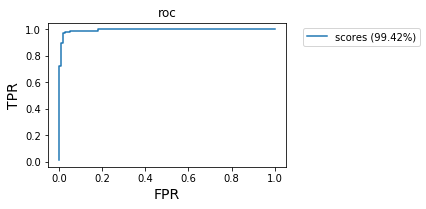

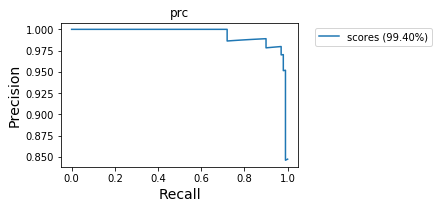

In [13]:
# do the evaluation on the independent test data
model.evaluate(DNA_TEST, ReduceDim(LABELS_TEST), datatags=['test'],
               callbacks=['auc', 'auprc', 'roc', 'prc'])

In [14]:
evaluation_folder = os.path.join(os.environ['JANGGU_OUTPUT'], 'evaluation', modelname, 'test')

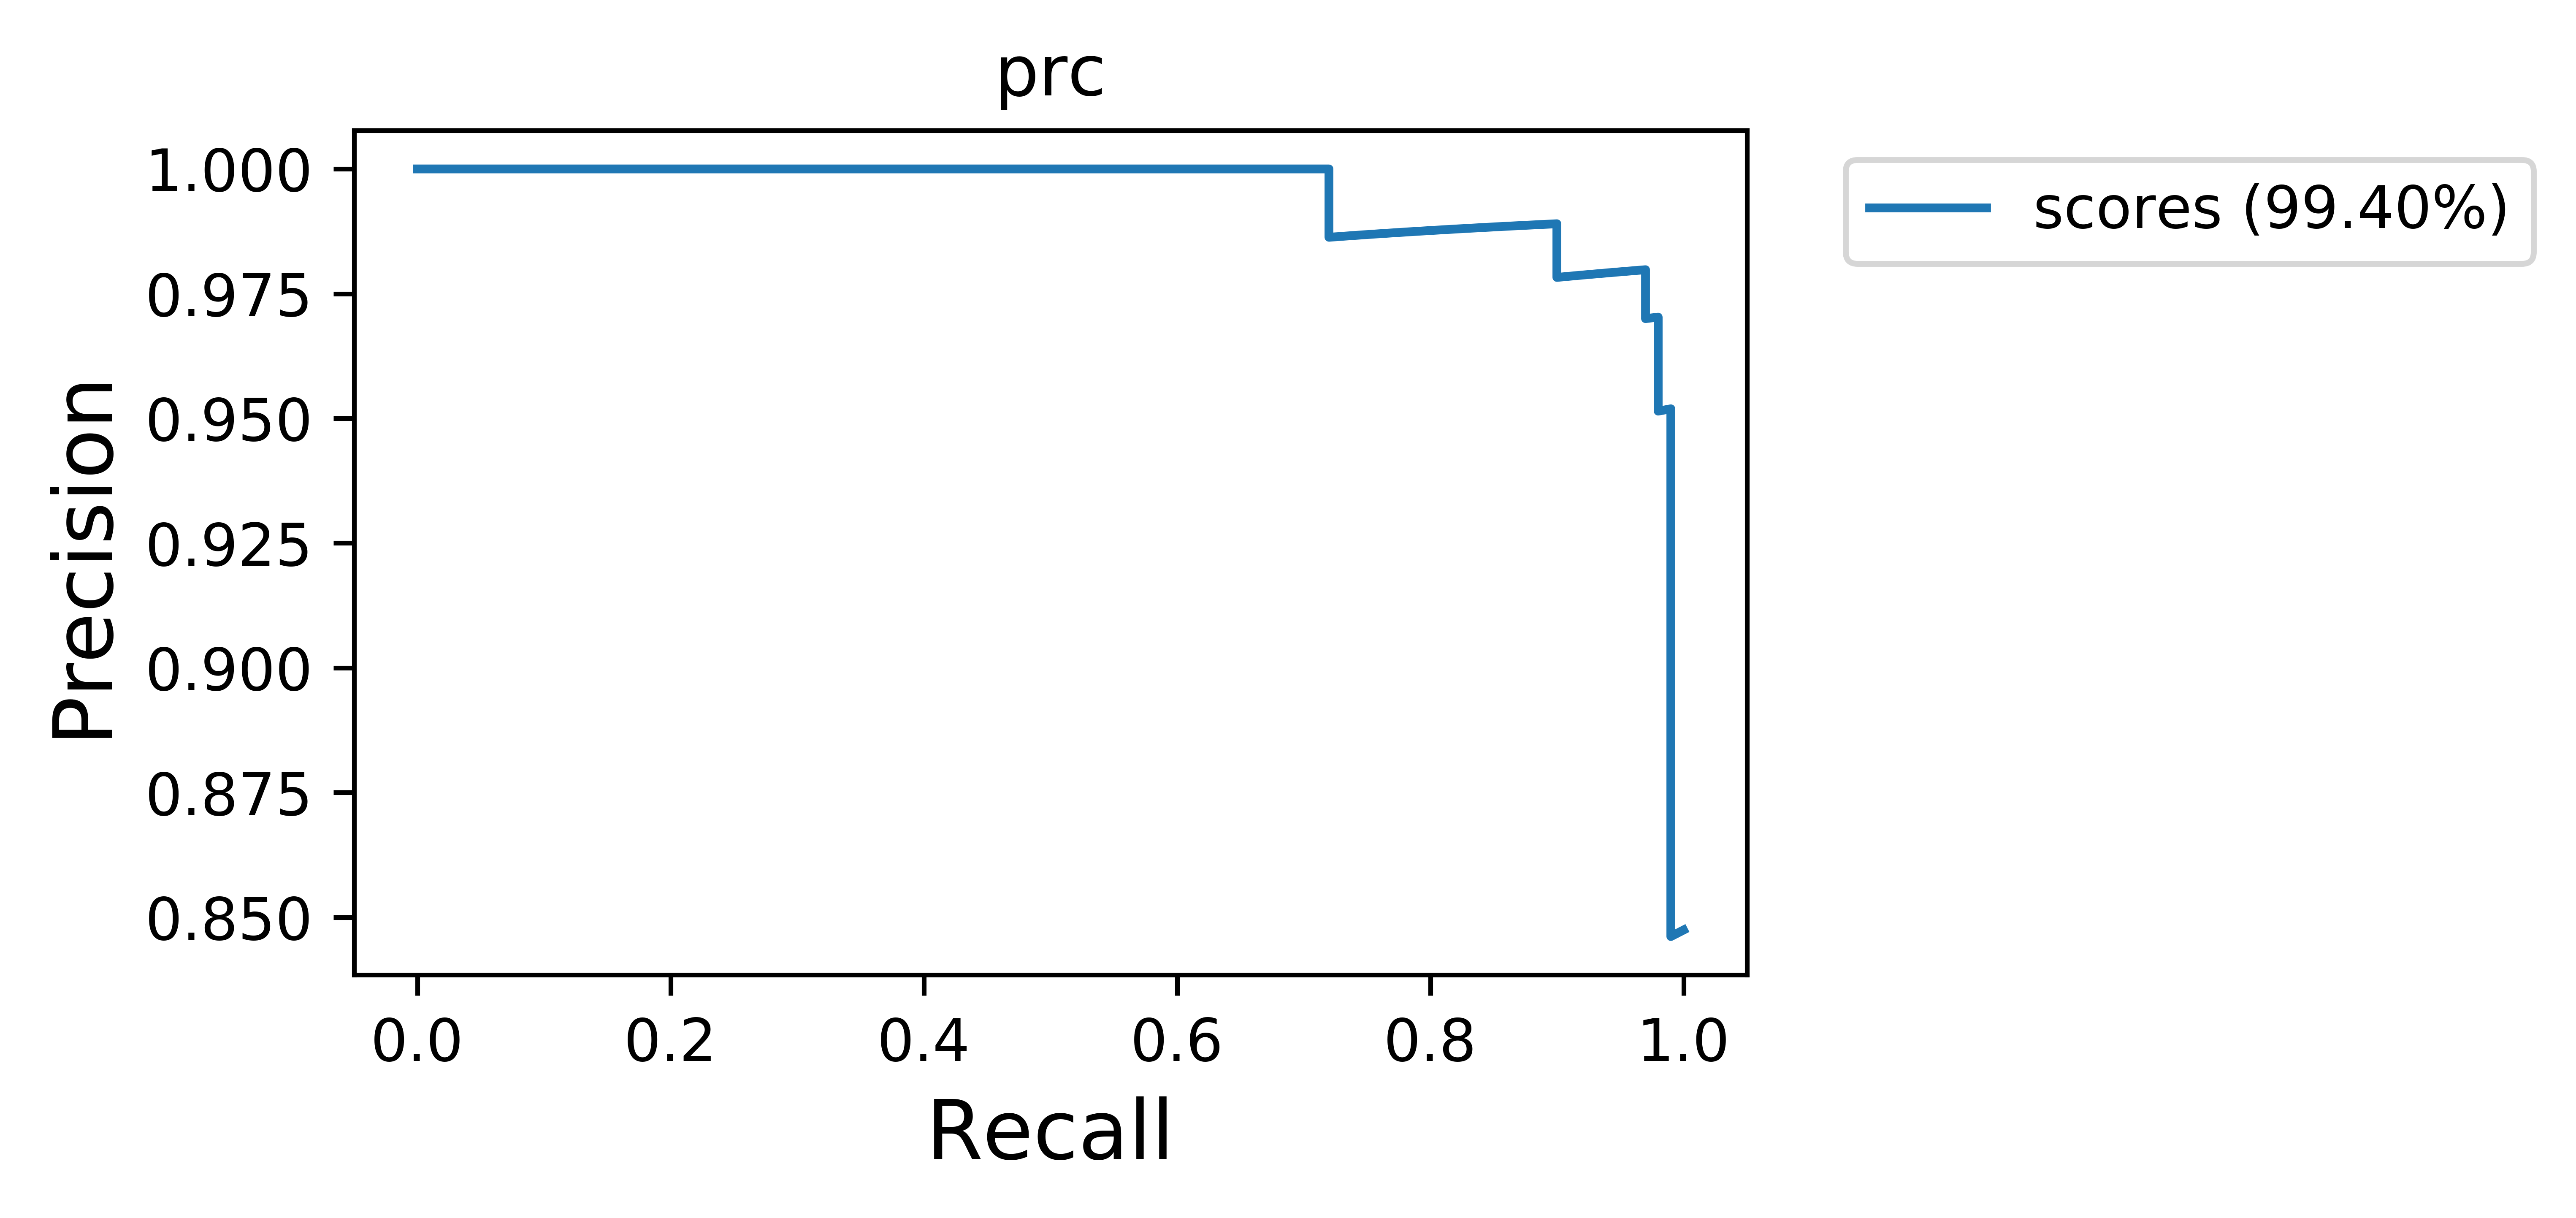

In [15]:
Image(os.path.join(evaluation_folder, 'prc.png'))

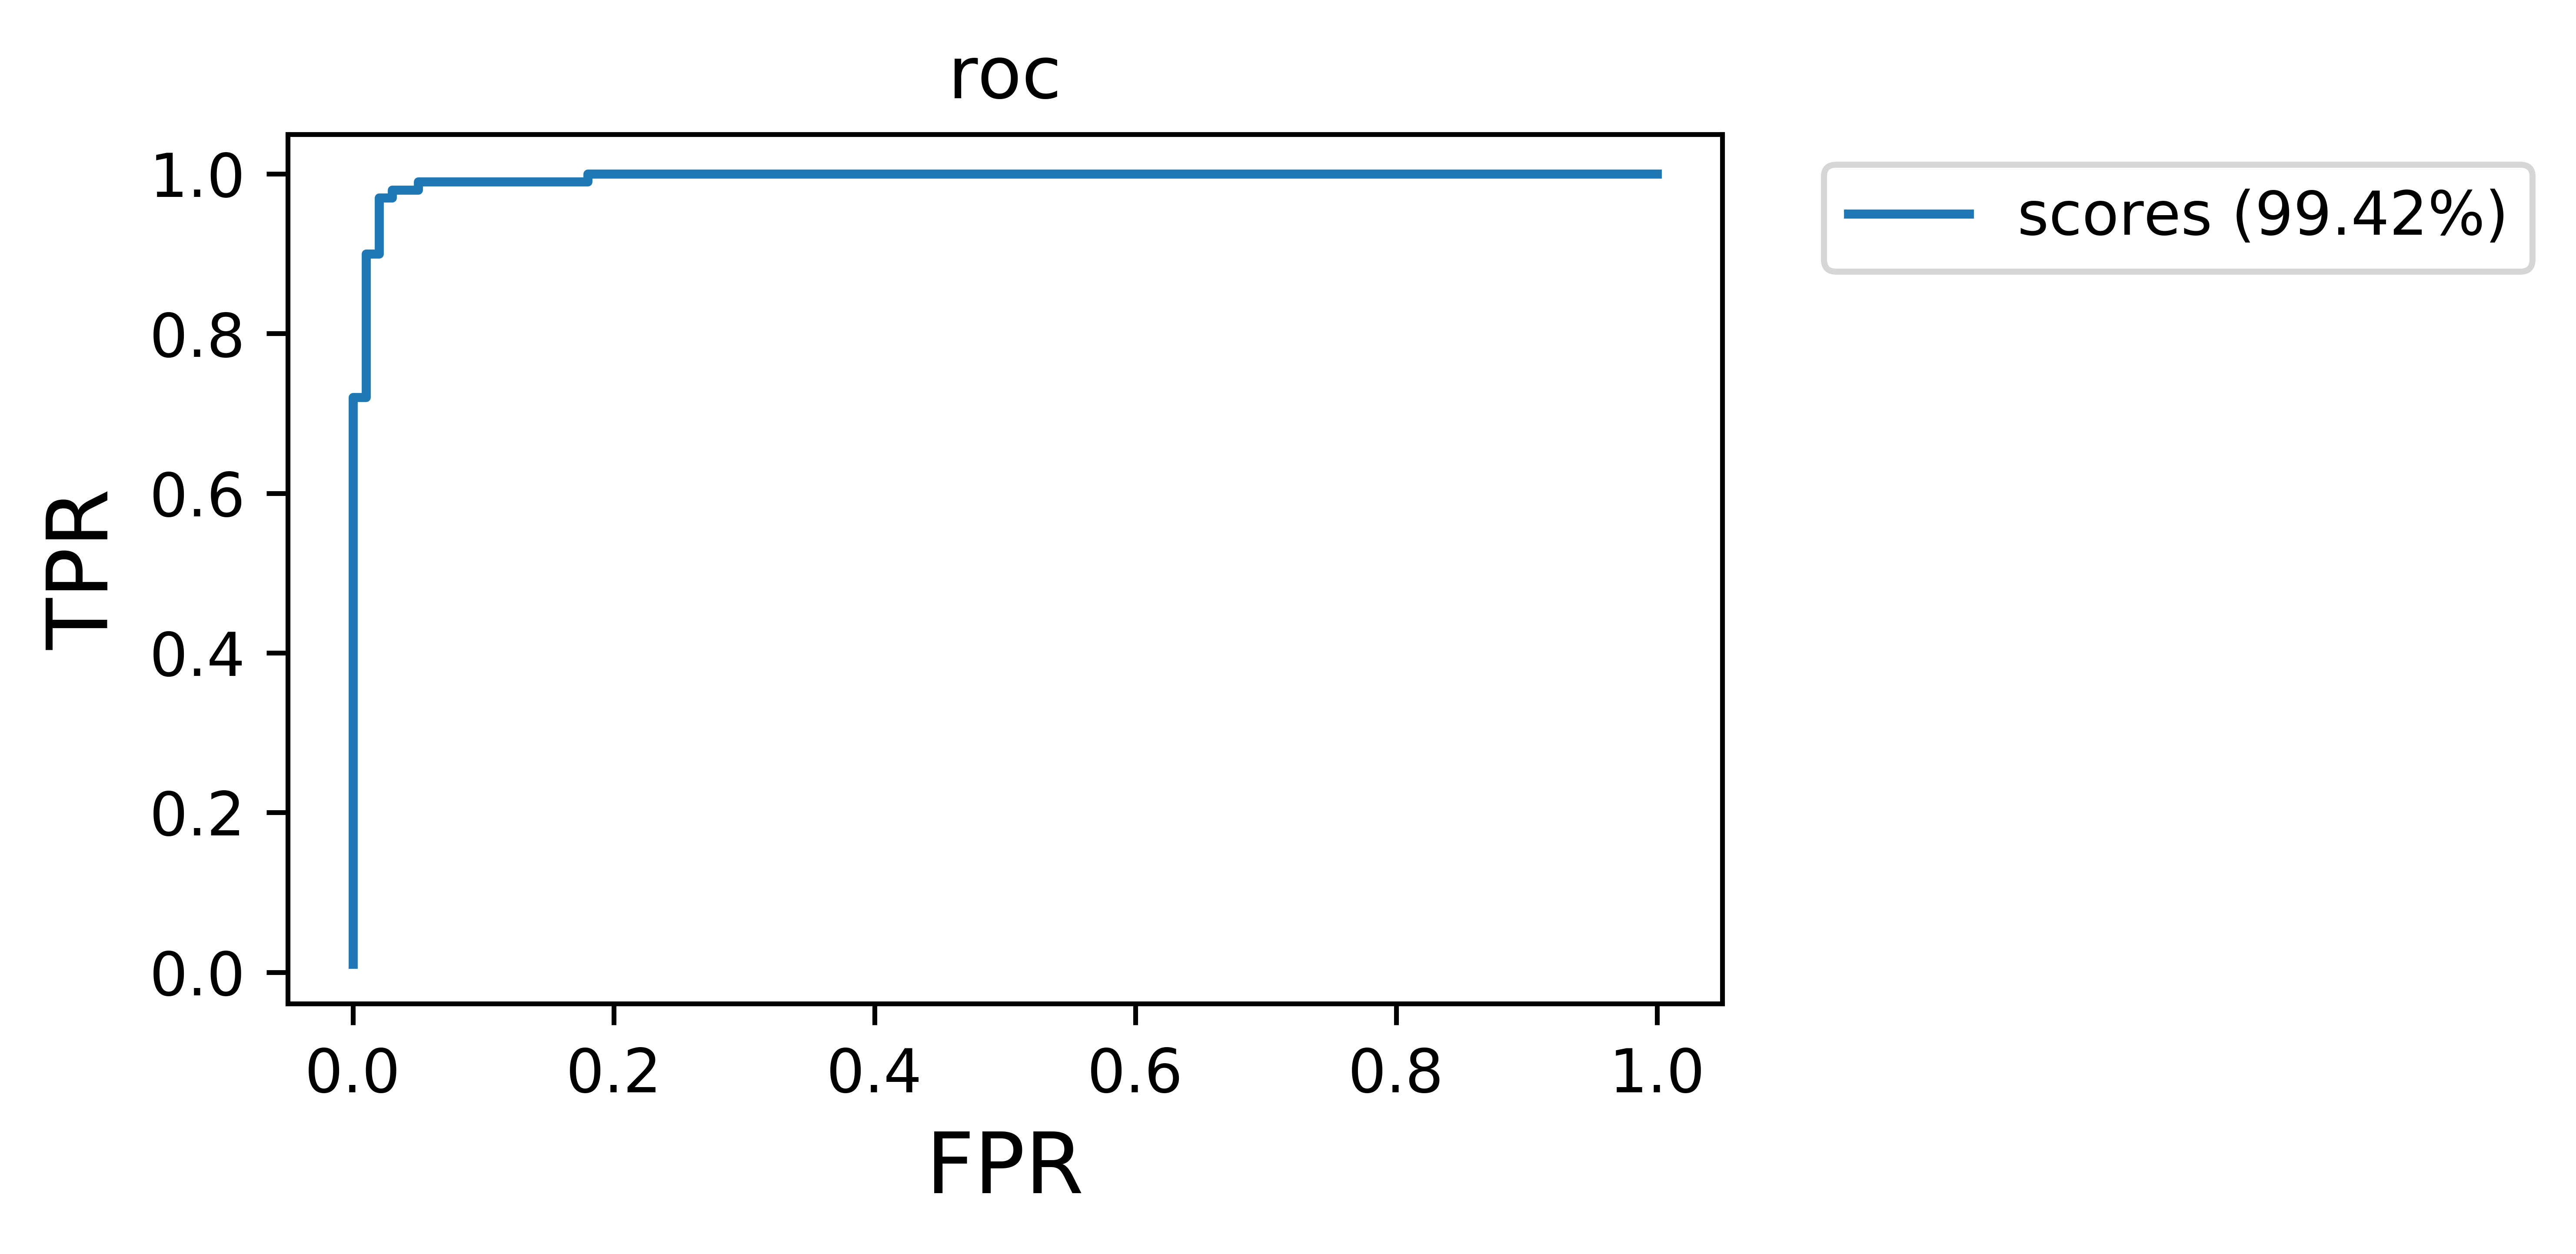

In [16]:
Image(os.path.join(evaluation_folder, 'roc.png'))

It is also possible to inspect the hidden layers for example by clustering the hidden feature activities. In this case, this is done for the 'motif' layer which is the first convolution layer.

array([[1.600911  , 0.4191686 , 0.59081465, ..., 1.9342976 , 0.28643346,
        0.5154825 ],
       [1.423312  , 0.4810649 , 0.59921515, ..., 1.7891194 , 0.43152866,
        0.5024406 ],
       [1.624104  , 0.43683857, 0.7034798 , ..., 1.8071641 , 0.34016404,
        0.6076513 ],
       ...,
       [1.6051155 , 0.6844147 , 0.70858073, ..., 1.7525921 , 0.6137494 ,
        0.86825794],
       [1.6730189 , 0.76110625, 0.74325955, ..., 1.97932   , 0.6314724 ,
        0.8976532 ],
       [1.5126992 , 0.40343815, 0.60530233, ..., 1.560414  , 0.4068123 ,
        0.57226604]], dtype=float32)

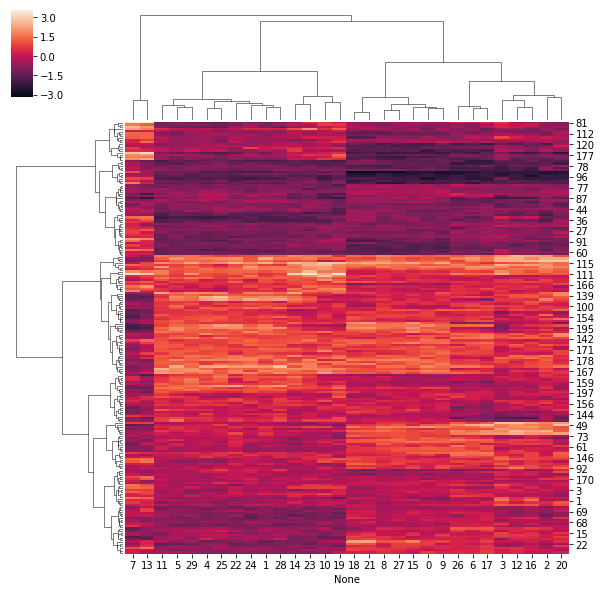

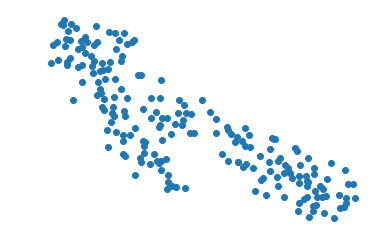

In [17]:
# clustering plots based on hidden features
heatmap_eval = Scorer('heatmap', exporter=ExportClustermap(z_score=1.))
tsne_eval = Scorer('tsne', exporter=ExportTsne())

model.predict(DNA_TEST, datatags=['test'],
              callbacks=[heatmap_eval, tsne_eval],
              layername='motif')

In addition it is possible to define custom Scorers if necessary.